# Entropy "model"

## Imports

In [1]:
from glob import glob
import json
import numpy as np
from os.path import basename
import pandas as pd
import PIL
import scipy.stats
import skimage.filters.rank 
from skimage.morphology import disk

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style("dark", {'axes.grid' : False})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load data

In [2]:
app_ui_exp = pd.read_pickle('../clean_data/app_ui_exp.pkl')
app_ui_exp.shape

(70959, 12)

In [3]:
app_ui_exp.head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[../app_uis/49783.jpg],1,../app_uis/49783.jpg,1080,1920,0.5625
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[../app_uis/26083.jpg],1,../app_uis/26083.jpg,1080,1920,0.5625


#### Resize screenshots to a more manageable size for entropy calculation using below script

In [4]:
! cat ../scripts/resize.py

from glob import glob
from PIL import Image
from os.path import basename

source_path = '../app_uis/'
dest_path = '../app_uis_resized/'

# loop over images and resize
for i, x in enumerate(glob(source_path + '*.jpg')):
    try:
        img = Image.open(x)
        size = img.size
        if size[0] < size[1]:
            img_resized = img.resize((270, 480), Image.ANTIALIAS)
        else:
            img_resized = img.resize((480, 270), Image.ANTIALIAS)
        img_resized.save(dest_path + basename(x))
    except OSError as e:
        pass
    if i % 1000 == 0:
        print(i)


#### Add column in dataframe for filepaths to resized images

In [5]:
app_ui_exp['resized_file'] = app_ui_exp.filename_exp.map(lambda x: '../app_uis_resized/' + basename(x))
app_ui_exp.head()

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[../app_uis/49783.jpg],1,../app_uis/49783.jpg,1080,1920,0.5625,../app_uis_resized/49783.jpg
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[../app_uis/26083.jpg],1,../app_uis/26083.jpg,1080,1920,0.5625,../app_uis_resized/26083.jpg
2,DOCECG2.doctor,Electrocardiogram ECG Types,Medical,3.9,4134.500000,500000.0,[../app_uis/51036.jpg],1,../app_uis/51036.jpg,1080,1920,0.5625,../app_uis_resized/51036.jpg
3,Gecko.Droid.PhysicsHelper,Pocket Physics,Education,4.1,15938.000000,1000000.0,"[../app_uis/29868.jpg, ../app_uis/29869.jpg, ....",5,../app_uis/29868.jpg,1080,1920,0.5625,../app_uis_resized/29868.jpg
4,Gecko.Droid.PhysicsHelper,Pocket Physics,Education,4.1,15938.000000,1000000.0,"[../app_uis/29868.jpg, ../app_uis/29869.jpg, ....",5,../app_uis/29869.jpg,1080,1920,0.5625,../app_uis_resized/29869.jpg


## Calculate histograms & entropies 

#### Sample data

In [ ]:
app_ui_exp.sample()

#### Add column in dataframe for grayscale histograms

In [20]:
def gs_histogram(filepath):
    return PIL.Image.open(filepath).convert('L').histogram()

In [23]:
app_ui_exp['gs_histogram'] = app_ui_exp.resized_file.map(lambda x: gs_histogram(x))

In [24]:
app_ui_exp.head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[../app_uis/49783.jpg],1,../app_uis/49783.jpg,1080,1920,0.5625,../app_uis_resized/49783.jpg,"[7495, 945, 498, 298, 210, 567, 162, 145, 106,..."
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[../app_uis/26083.jpg],1,../app_uis/26083.jpg,1080,1920,0.5625,../app_uis_resized/26083.jpg,"[9609, 626, 310, 1090, 264, 699, 1081, 426, 41..."


In [26]:
len(app_ui_exp.gs_histogram[0])

256

#### Add column in dataframe for grayscale entropies

In [27]:
def ui_entropy(vector):
    probabilities = [(float(i)/sum(vector)) for i in vector]
    return -sum([p * np.log2(p) for p in probabilities if p != 0])

In [28]:
app_ui_exp['gs_ent'] = app_ui_exp.gs_histogram.map(lambda x: ui_entropy(x))

In [29]:
app_ui_exp.head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[../app_uis/49783.jpg],1,../app_uis/49783.jpg,1080,1920,0.5625,../app_uis_resized/49783.jpg,"[7495, 945, 498, 298, 210, 567, 162, 145, 106,...",4.289600
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[../app_uis/26083.jpg],1,../app_uis/26083.jpg,1080,1920,0.5625,../app_uis_resized/26083.jpg,"[9609, 626, 310, 1090, 264, 699, 1081, 426, 41...",6.826821


#### Add column in dataframe for color histograms

In [30]:
def c_histogram(filepath):
    return PIL.Image.open(filepath).histogram()

In [31]:
app_ui_exp['c_histogram'] = app_ui_exp.resized_file.map(lambda x: c_histogram(x))

In [32]:
app_ui_exp.head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[../app_uis/49783.jpg],1,../app_uis/49783.jpg,1080,1920,0.5625,../app_uis_resized/49783.jpg,"[7495, 945, 498, 298, 210, 567, 162, 145, 106,...",4.289600,"[7682, 724, 414, 187, 356, 370, 187, 113, 89, ..."
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[../app_uis/26083.jpg],1,../app_uis/26083.jpg,1080,1920,0.5625,../app_uis_resized/26083.jpg,"[9609, 626, 310, 1090, 264, 699, 1081, 426, 41...",6.826821,"[9609, 626, 310, 1090, 264, 699, 1081, 426, 41..."


In [33]:
len(app_ui_exp.c_histogram[0])

768

#### Add column in dataframe for color entropies

In [34]:
app_ui_exp['c_ent'] = app_ui_exp.c_histogram.map(lambda x: ui_entropy(x))

In [35]:
app_ui_exp.head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram,c_ent
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[../app_uis/49783.jpg],1,../app_uis/49783.jpg,1080,1920,0.5625,../app_uis_resized/49783.jpg,"[7495, 945, 498, 298, 210, 567, 162, 145, 106,...",4.289600,"[7682, 724, 414, 187, 356, 370, 187, 113, 89, ...",5.835544
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[../app_uis/26083.jpg],1,../app_uis/26083.jpg,1080,1920,0.5625,../app_uis_resized/26083.jpg,"[9609, 626, 310, 1090, 264, 699, 1081, 426, 41...",6.826821,"[9609, 626, 310, 1090, 264, 699, 1081, 426, 41...",8.411783


#### Add column for Information Gain
from going to a larger state space (3 color channels) to a smaller state space (grayscale)

In [49]:
app_ui_exp['info_gain'] = app_ui_exp.c_ent - app_ui_exp.gs_ent

In [50]:
app_ui_exp.head()

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram,c_ent,info_gain
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[../app_uis/49783.jpg],1,../app_uis/49783.jpg,1080,1920,0.5625,../app_uis_resized/49783.jpg,"[7495, 945, 498, 298, 210, 567, 162, 145, 106,...",4.289600,"[7682, 724, 414, 187, 356, 370, 187, 113, 89, ...",5.835544,1.545944
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[../app_uis/26083.jpg],1,../app_uis/26083.jpg,1080,1920,0.5625,../app_uis_resized/26083.jpg,"[9609, 626, 310, 1090, 264, 699, 1081, 426, 41...",6.826821,"[9609, 626, 310, 1090, 264, 699, 1081, 426, 41...",8.411783,1.584963
2,DOCECG2.doctor,Electrocardiogram ECG Types,Medical,3.9,4134.500000,500000.0,[../app_uis/51036.jpg],1,../app_uis/51036.jpg,1080,1920,0.5625,../app_uis_resized/51036.jpg,"[9294, 2579, 971, 879, 2325, 4784, 1136, 405, ...",5.371557,"[9684, 2034, 770, 1632, 3345, 2579, 1146, 379,...",7.330149,1.958592
3,Gecko.Droid.PhysicsHelper,Pocket Physics,Education,4.1,15938.000000,1000000.0,"[../app_uis/29868.jpg, ../app_uis/29869.jpg, ....",5,../app_uis/29868.jpg,1080,1920,0.5625,../app_uis_resized/29868.jpg,"[6653, 861, 320, 54, 37, 22, 35, 37, 18, 22, 1...",2.328049,"[6996, 913, 400, 122, 112, 129, 673, 174, 206,...",3.888235,1.560187
4,Gecko.Droid.PhysicsHelper,Pocket Physics,Education,4.1,15938.000000,1000000.0,"[../app_uis/29868.jpg, ../app_uis/29869.jpg, ....",5,../app_uis/29869.jpg,1080,1920,0.5625,../app_uis_resized/29869.jpg,"[7193, 321, 50, 54, 307, 22, 35, 37, 18, 22, 1...",4.286205,"[7852, 414, 166, 188, 438, 414, 445, 301, 264,...",5.830920,1.544715


#### Save resulting dataframe
Calculating these histograms and entropies took a long time to run!

In [36]:
app_ui_exp.to_pickle('../clean_data/app_ui_ents.pkl')

## Analysis

### Entropy Distribution for grayscale images

In [65]:
app_ui_exp.gs_ent.describe()

count    70959.000000
mean         4.659513
std          1.520025
min         -0.000000
25%          3.507585
50%          4.650806
75%          5.847146
max          7.880184
Name: gs_ent, dtype: float64

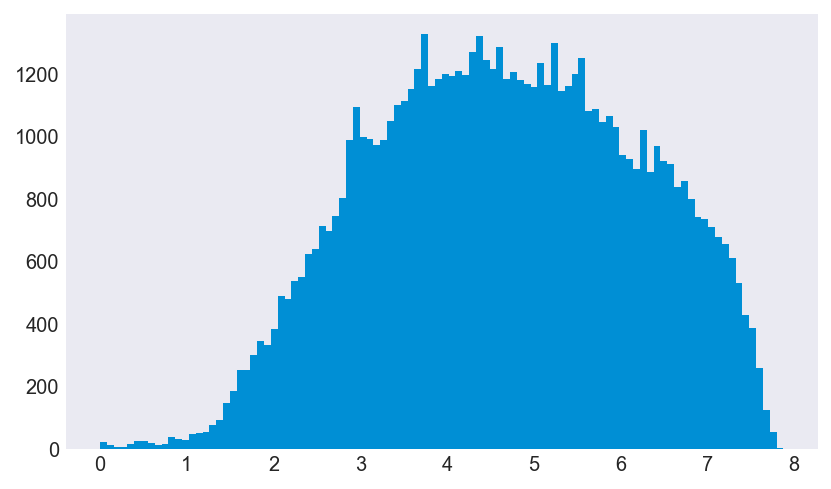

In [40]:
plt.hist(app_ui_exp.gs_ent, bins=100);

#### Lowest entropy grayscale image

In [70]:
app_ui_exp[app_ui_exp.gs_ent == 0].head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram,c_ent,info_gain
15137,com.designmantic,Logo Maker by DesignMantic,Business,3.1,6006.0,1000000.0,"[../app_uis/50792.jpg, ../app_uis/50786.jpg, ....",8,../app_uis/50788.jpg,1920,1080,1.777778,../app_uis_resized/50788.jpg,"[129600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",-0.0,"[129600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1.584963,1.584963
27390,com.inglesdivino.imagestovideo,Photos To Video,Video Players & Editors,3.7,6213.0,1000000.0,"[../app_uis/70123.jpg, ../app_uis/70124.jpg, ....",9,../app_uis/70117.jpg,1080,1920,0.562500,../app_uis_resized/70117.jpg,"[129600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",-0.0,"[129600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1.584963,1.584963


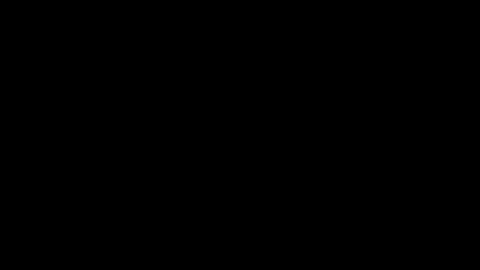

In [75]:
PIL.Image.open(app_ui_exp.resized_file[15137]).convert('L')

#### Highest entropy grayscale image

In [77]:
app_ui_exp[app_ui_exp.gs_ent > 7.88].head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram,c_ent,info_gain
66456,net.kreci.crackedscreen,Cracked Screen Prank,Entertainment,3.6,5311.0,1000000.0,"[../app_uis/16785.jpg, ../app_uis/16784.jpg, ....",3,../app_uis/16785.jpg,540,960,0.5625,../app_uis_resized/16785.jpg,"[7, 11, 27, 33, 34, 40, 43, 40, 52, 70, 93, 79...",7.880184,"[80, 14, 16, 17, 25, 27, 35, 44, 44, 47, 53, 5...",9.427174,1.546991


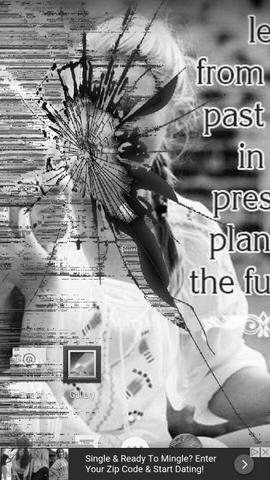

In [78]:
PIL.Image.open(app_ui_exp.resized_file[66456]).convert('L')

### Entropy Distribution for color images

In [66]:
app_ui_exp.c_ent.describe()

count    70959.000000
mean         6.207805
std          1.512898
min          1.584963
25%          5.056105
50%          6.200591
75%          7.396267
max          9.427174
Name: c_ent, dtype: float64

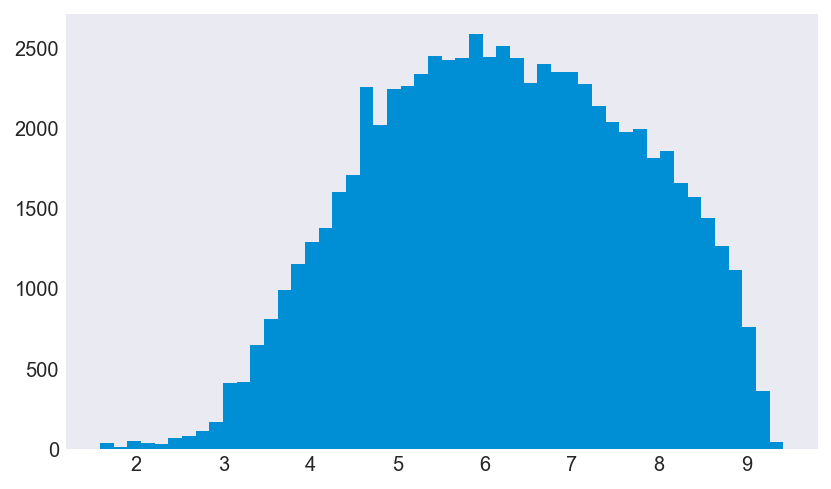

In [41]:
plt.hist(app_ui_exp.c_ent, bins=50);

#### Lowest entropy color image

In [81]:
app_ui_exp[app_ui_exp.c_ent < 1.59].head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram,c_ent,info_gain
15137,com.designmantic,Logo Maker by DesignMantic,Business,3.1,6006.0,1000000.0,"[../app_uis/50792.jpg, ../app_uis/50786.jpg, ....",8,../app_uis/50788.jpg,1920,1080,1.777778,../app_uis_resized/50788.jpg,"[129600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",-0.0,"[129600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1.584963,1.584963
27390,com.inglesdivino.imagestovideo,Photos To Video,Video Players & Editors,3.7,6213.0,1000000.0,"[../app_uis/70123.jpg, ../app_uis/70124.jpg, ....",9,../app_uis/70117.jpg,1080,1920,0.562500,../app_uis_resized/70117.jpg,"[129600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",-0.0,"[129600, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1.584963,1.584963


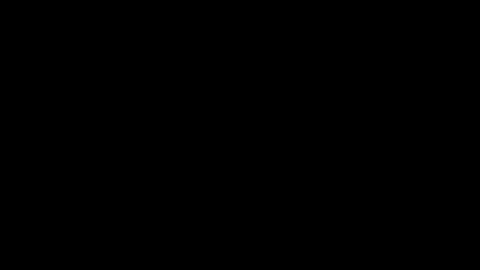

In [92]:
# same image as above for grayscale
# likely the extremes here won't vary much
PIL.Image.open(app_ui_exp.resized_file[15137])

#### Highest entropy color image

In [86]:
app_ui_exp[app_ui_exp.c_ent > 9.4].head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram,c_ent,info_gain
66456,net.kreci.crackedscreen,Cracked Screen Prank,Entertainment,3.6,5311.0,1000000.0,"[../app_uis/16785.jpg, ../app_uis/16784.jpg, ....",3,../app_uis/16785.jpg,540,960,0.5625,../app_uis_resized/16785.jpg,"[7, 11, 27, 33, 34, 40, 43, 40, 52, 70, 93, 79...",7.880184,"[80, 14, 16, 17, 25, 27, 35, 44, 44, 47, 53, 5...",9.427174,1.546991
66457,net.kreci.crackedscreen,Cracked Screen Prank,Entertainment,3.6,5311.0,1000000.0,"[../app_uis/16785.jpg, ../app_uis/16784.jpg, ....",3,../app_uis/16784.jpg,540,960,0.5625,../app_uis_resized/16784.jpg,"[7, 13, 29, 28, 33, 38, 41, 41, 53, 72, 86, 73...",7.861527,"[88, 13, 15, 18, 24, 26, 36, 44, 45, 41, 52, 5...",9.413489,1.551962


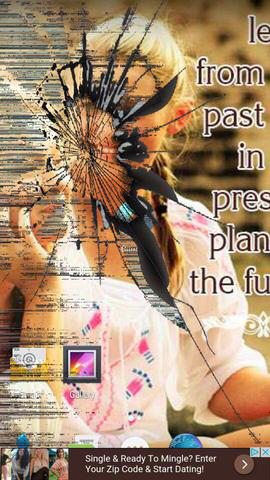

In [88]:
# same image as above for color
PIL.Image.open(app_ui_exp.resized_file[66456])

### Entropy with regards to app category

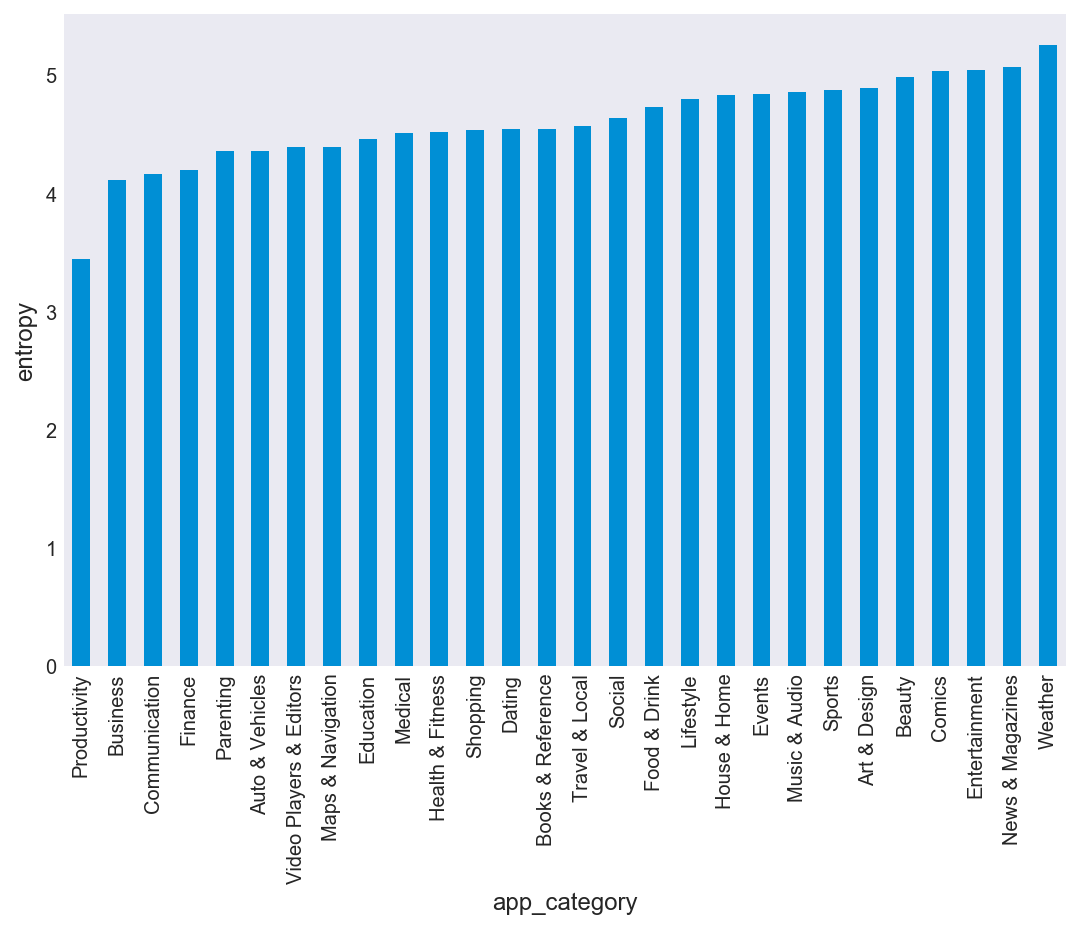

In [89]:
app_ui_exp.groupby('app_category')['gs_ent'].mean().sort_values().plot.bar(figsize=(8,6)).set_ylabel('entropy');

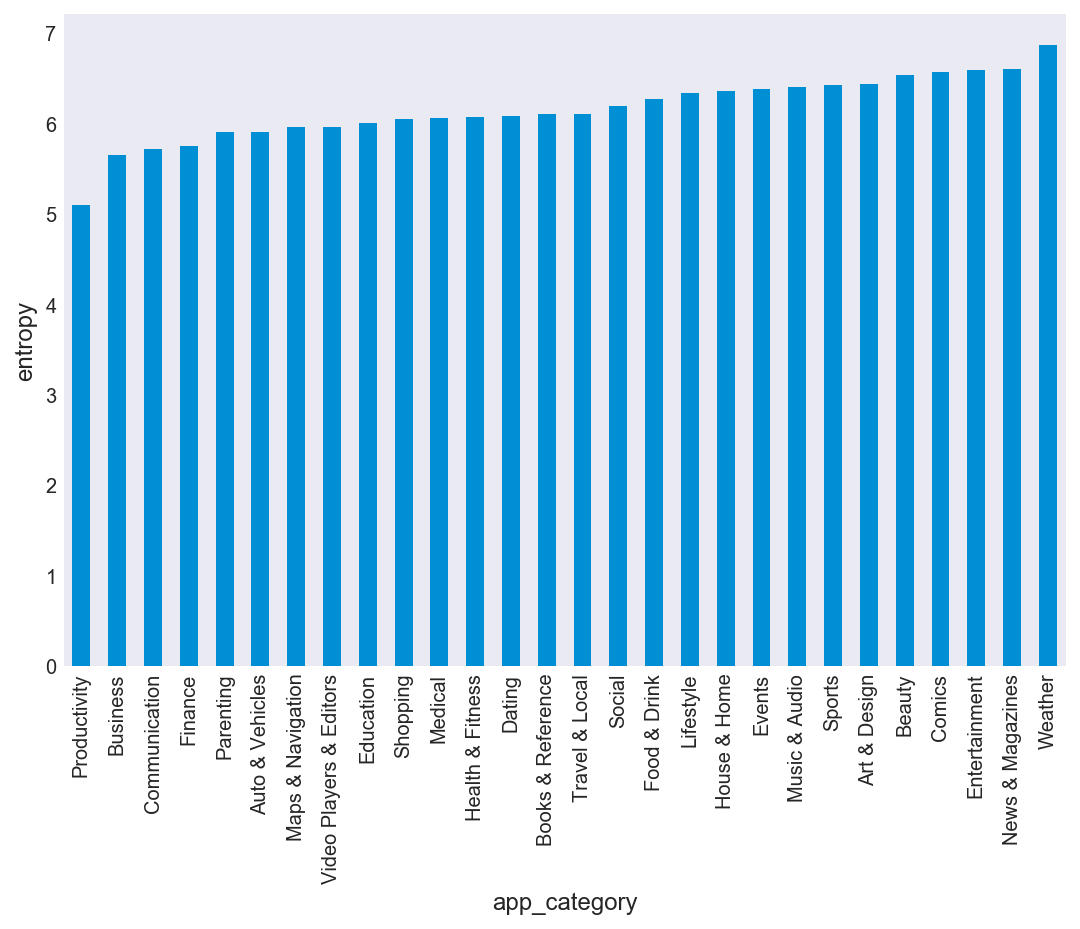

In [57]:
app_ui_exp.groupby('app_category')['c_ent'].mean().sort_values().plot.bar(figsize=(8,6)).set_ylabel('entropy');

#### Lowest entropy image in Productivity category

In [91]:
app_ui_exp[app_ui_exp.app_category == 'Productivity'].sort_values(by='gs_ent').head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram,c_ent,info_gain
45717,com.sftx.repost,Repost for Instagram RepostIt,Productivity,4.1,25836.0,1000000.0,"[../app_uis/38953.jpg, ../app_uis/38949.jpg, ....",6,../app_uis/38951.jpg,540,960,0.5625,../app_uis_resized/38951.jpg,"[6597, 585, 44, 43, 314, 35, 43, 37, 303, 38, ...",2.770600,"[6597, 585, 44, 43, 314, 35, 43, 37, 303, 38, ...",4.389115,1.618515
45720,com.sftx.repost,Repost for Instagram RepostIt,Productivity,4.1,25836.0,1000000.0,"[../app_uis/38953.jpg, ../app_uis/38949.jpg, ....",6,../app_uis/38952.jpg,540,960,0.5625,../app_uis_resized/38952.jpg,"[6091, 77, 800, 322, 294, 289, 41, 30, 32, 40,...",2.937898,"[8177, 1232, 1473, 691, 603, 407, 282, 121, 19...",4.902454,1.964556


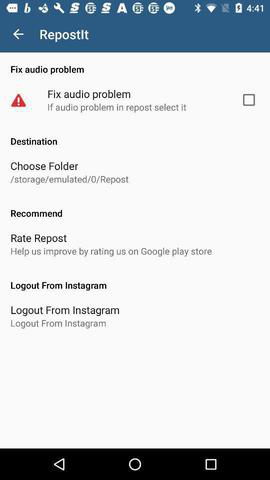

In [64]:
PIL.Image.open(app_ui_exp.resized_file[45717])

#### Highest entropy image in Weather category

In [97]:
app_ui_exp[app_ui_exp.app_category == 'Weather'].sort_values(by='gs_ent', ascending=False).head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram,c_ent,info_gain
64351,local.weather.forecast.pro,Weather Ultimate,Weather,4.2,76745.666667,1000000.0,"[../app_uis/46065.jpg, ../app_uis/46068.jpg, ....",5,../app_uis/46068.jpg,540,960,0.5625,../app_uis_resized/46068.jpg,"[8156, 727, 573, 358, 354, 437, 301, 242, 235,...",7.748507,"[8579, 662, 542, 445, 369, 429, 343, 285, 290,...",9.315989,1.567482
64350,local.weather.forecast.pro,Weather Ultimate,Weather,4.2,76745.666667,1000000.0,"[../app_uis/46065.jpg, ../app_uis/46068.jpg, ....",5,../app_uis/46065.jpg,540,960,0.5625,../app_uis_resized/46065.jpg,"[8215, 715, 606, 422, 322, 364, 259, 226, 219,...",7.746836,"[8667, 634, 563, 450, 355, 399, 327, 264, 292,...",9.316586,1.569750


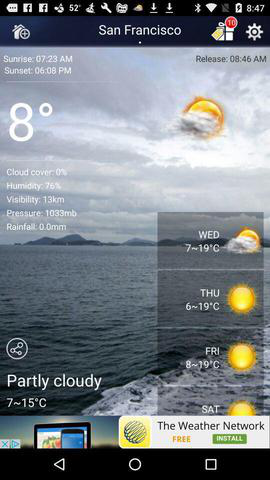

In [98]:
PIL.Image.open(app_ui_exp.resized_file[64351])

### Entropy with regards to star rating

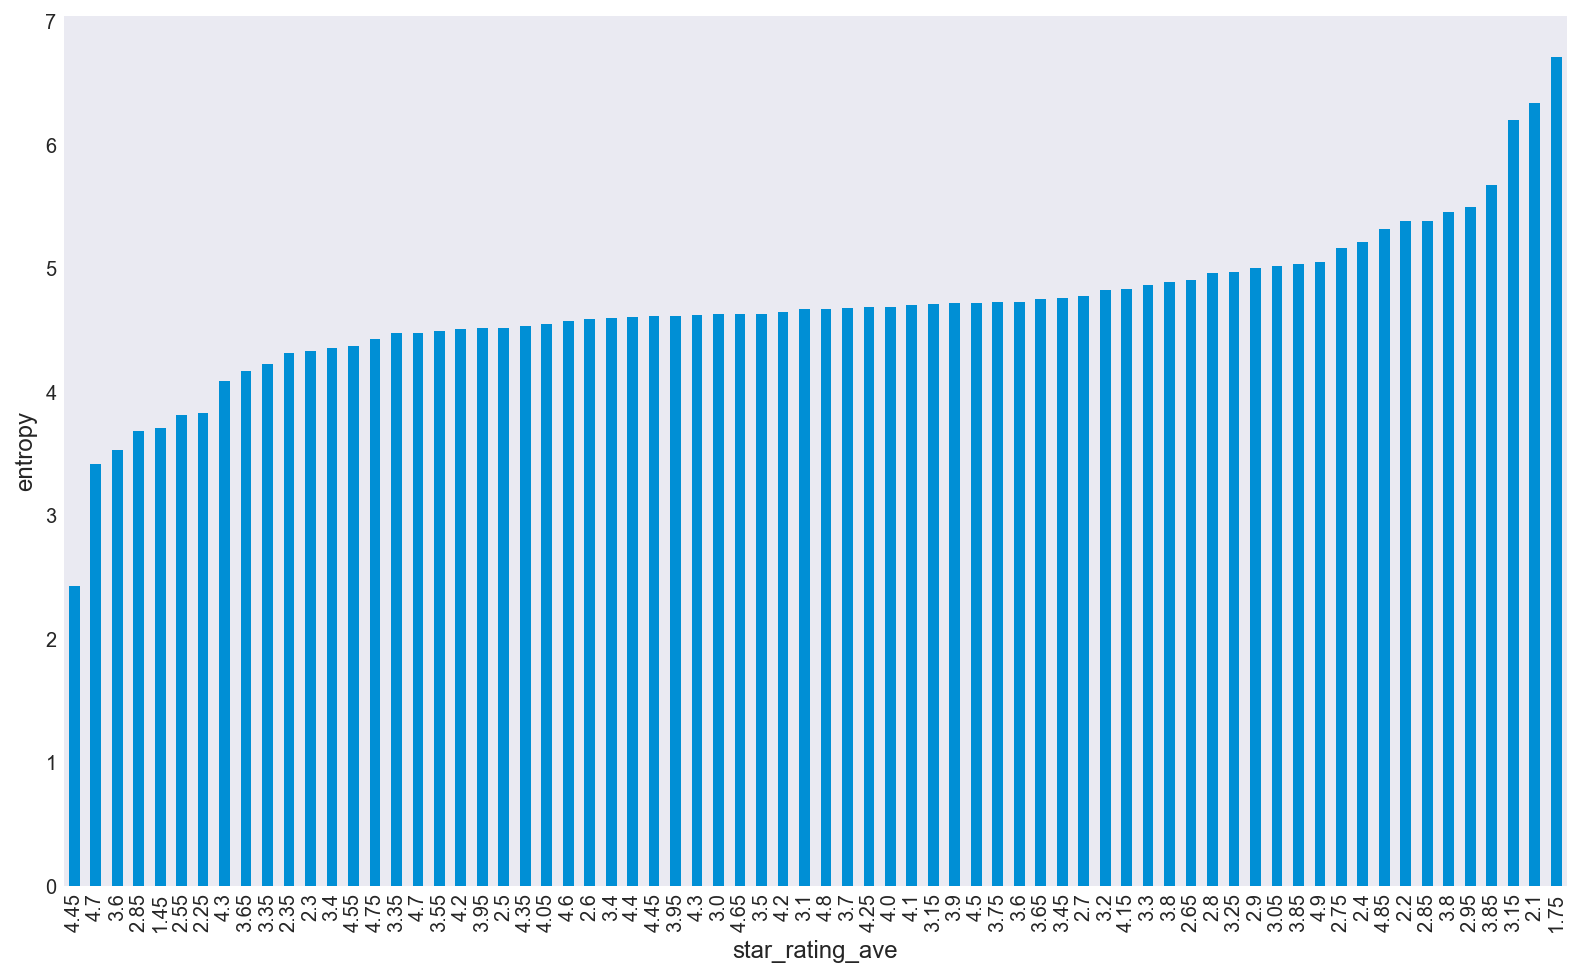

In [56]:
app_ui_exp.groupby('star_rating_ave')['gs_ent'].mean().sort_values().plot.bar(figsize=(12,8)).set_ylabel('entropy');

#### Most poorly rated app

In [114]:
app_ui_exp[app_ui_exp.star_rating_ave < 1.5].sort_values(by='gs_ent', ascending=True).head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram,c_ent,info_gain
1901,co.inbox.messenger,Inbox Messenger: Chat Room App,Communication,1.45,3890.0,500000.0,"[../app_uis/30776.jpg, ../app_uis/30771.jpg, ....",26,../app_uis/30753.jpg,1080,1920,0.5625,../app_uis_resized/30753.jpg,"[6653, 861, 320, 54, 37, 22, 35, 37, 18, 22, 1...",2.310716,"[7685, 995, 633, 178, 177, 146, 130, 150, 114,...",3.768919,1.458203
1921,co.inbox.messenger,Inbox Messenger: Chat Room App,Communication,1.45,3890.0,500000.0,"[../app_uis/30776.jpg, ../app_uis/30771.jpg, ....",26,../app_uis/30773.jpg,1080,1920,0.5625,../app_uis_resized/30773.jpg,"[56283, 27617, 12203, 9088, 2334, 413, 53, 14,...",2.365556,"[8810, 16926, 50108, 2297, 6466, 11064, 8148, ...",3.938909,1.573352


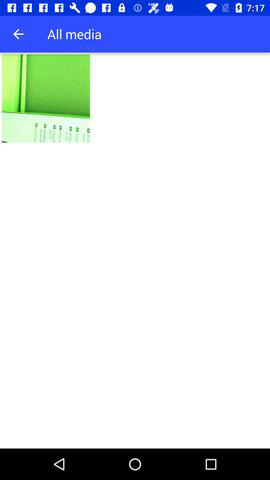

In [115]:
PIL.Image.open(app_ui_exp.resized_file[1901])

#### Best rated app

In [129]:
app_ui_exp[app_ui_exp.star_rating_ave > 4.4].sort_values(by='gs_ent', ascending=True).head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio,resized_file,gs_histogram,gs_ent,c_histogram,c_ent,info_gain
13916,com.cowboys.attstadium.android,AT&T Stadium,Sports,4.60,1011.0,50000.0,"[../app_uis/8624.jpg, ../app_uis/8621.jpg, ../...",7,../app_uis/8624.jpg,1080,1920,0.5625,../app_uis_resized/8624.jpg,"[128963, 51, 50, 54, 37, 22, 35, 37, 18, 22, 1...",0.073849,"[128963, 51, 50, 54, 37, 22, 35, 37, 18, 22, 1...",1.658812,1.584963
61141,easy.to.read.bible.free,Easy to read Bible,Books & Reference,4.75,4342.0,100000.0,"[../app_uis/8844.jpg, ../app_uis/8842.jpg, ../...",14,../app_uis/8836.jpg,1080,1920,0.5625,../app_uis_resized/8836.jpg,"[128963, 51, 50, 54, 37, 22, 35, 37, 18, 22, 1...",0.073849,"[128963, 51, 50, 54, 37, 22, 35, 37, 18, 22, 1...",1.658812,1.584963


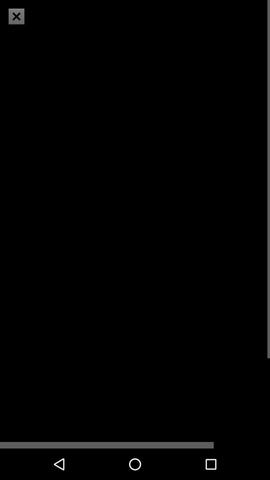

In [128]:
PIL.Image.open(app_ui_exp.resized_file[14826])

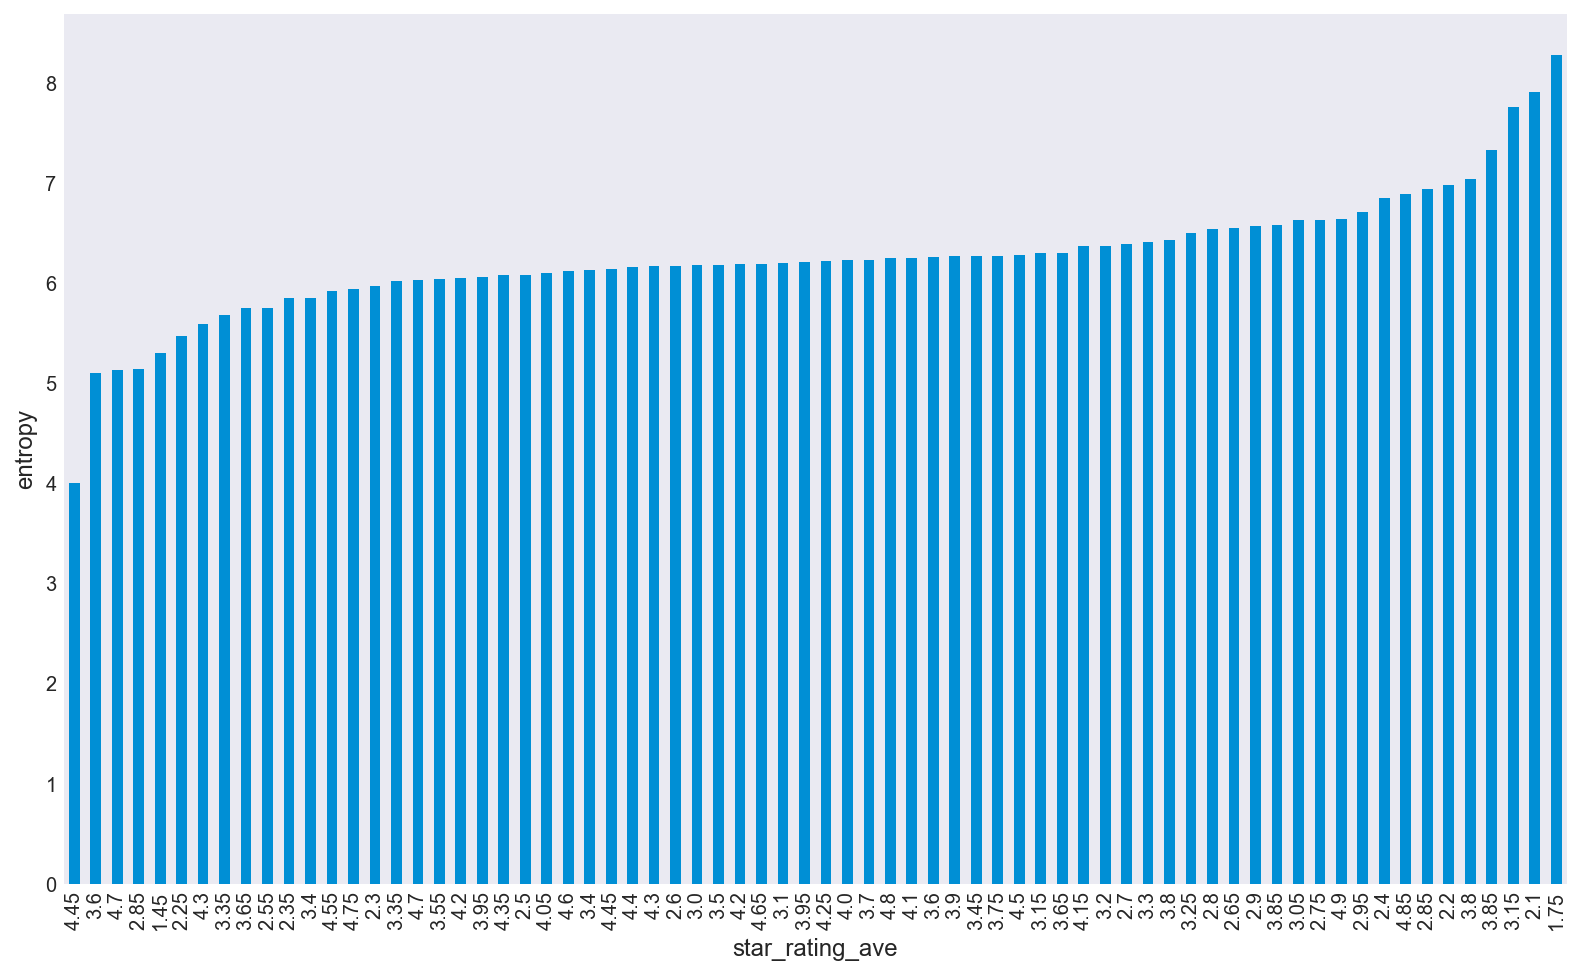

In [55]:
app_ui_exp.groupby('star_rating_ave')['c_ent'].mean().sort_values().plot.bar(figsize=(12,8)).set_ylabel('entropy');

### Information Gain

In [130]:
app_ui_exp.info_gain.describe()

count    70959.000000
mean         1.548292
std          0.151678
min          0.053565
25%          1.479022
50%          1.563807
75%          1.619920
max          3.234478
Name: info_gain, dtype: float64

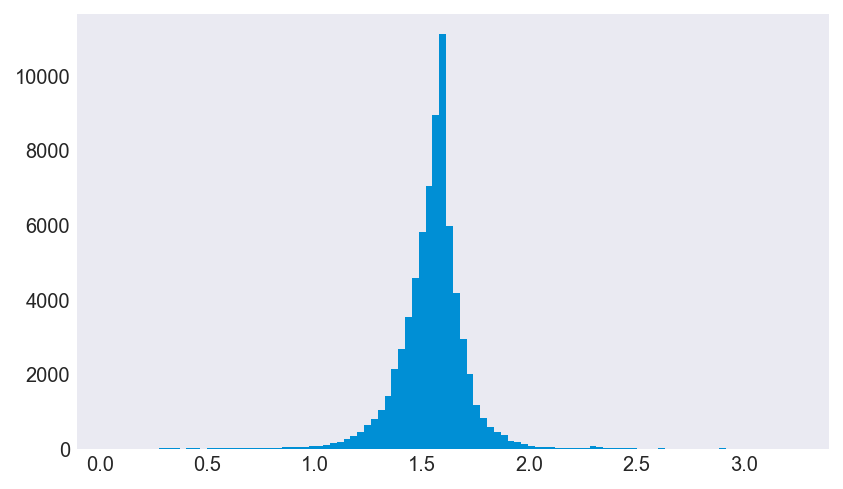

In [131]:
plt.hist(app_ui_exp.info_gain, bins=100);

### Info gain with regards to app category

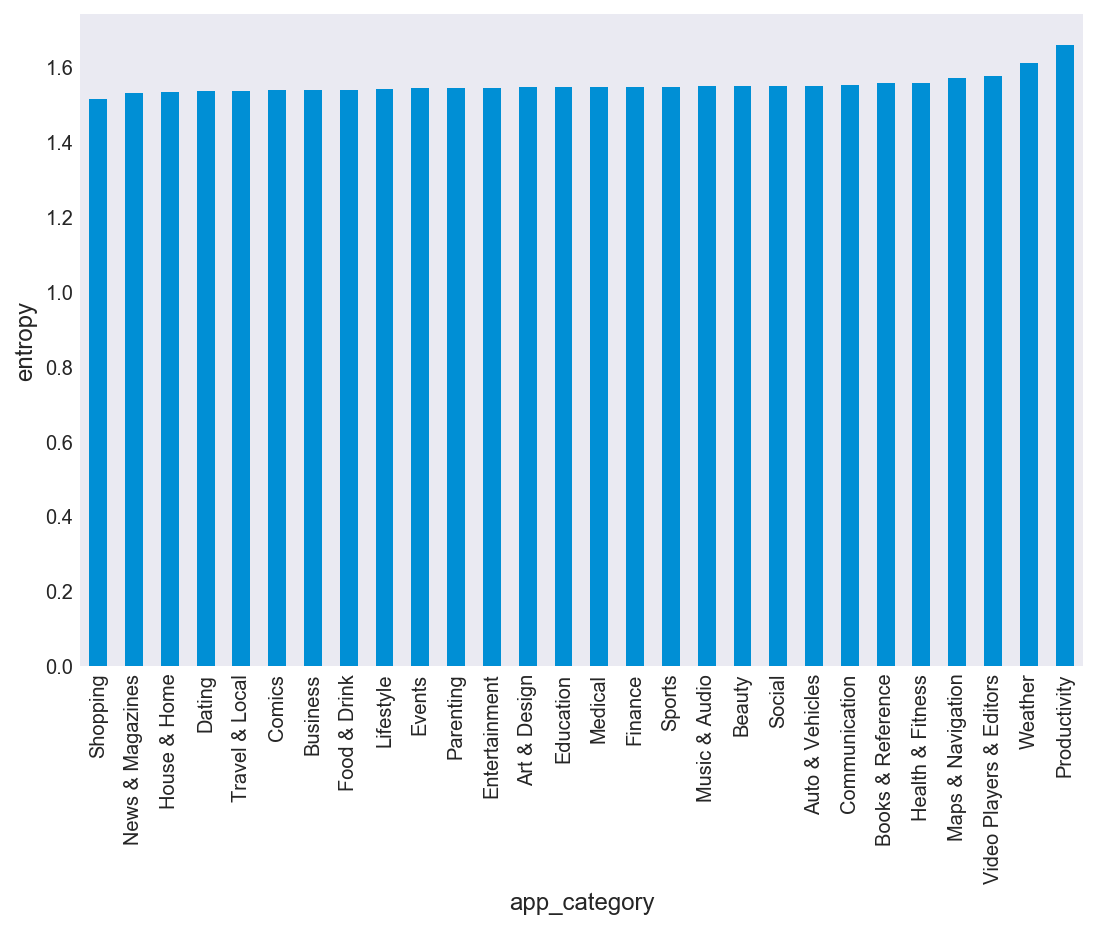

In [133]:
app_ui_exp.groupby('app_category')['info_gain'].mean().sort_values().plot.bar(figsize=(8,6)).set_ylabel('entropy');

### Info gain with regards to star rating

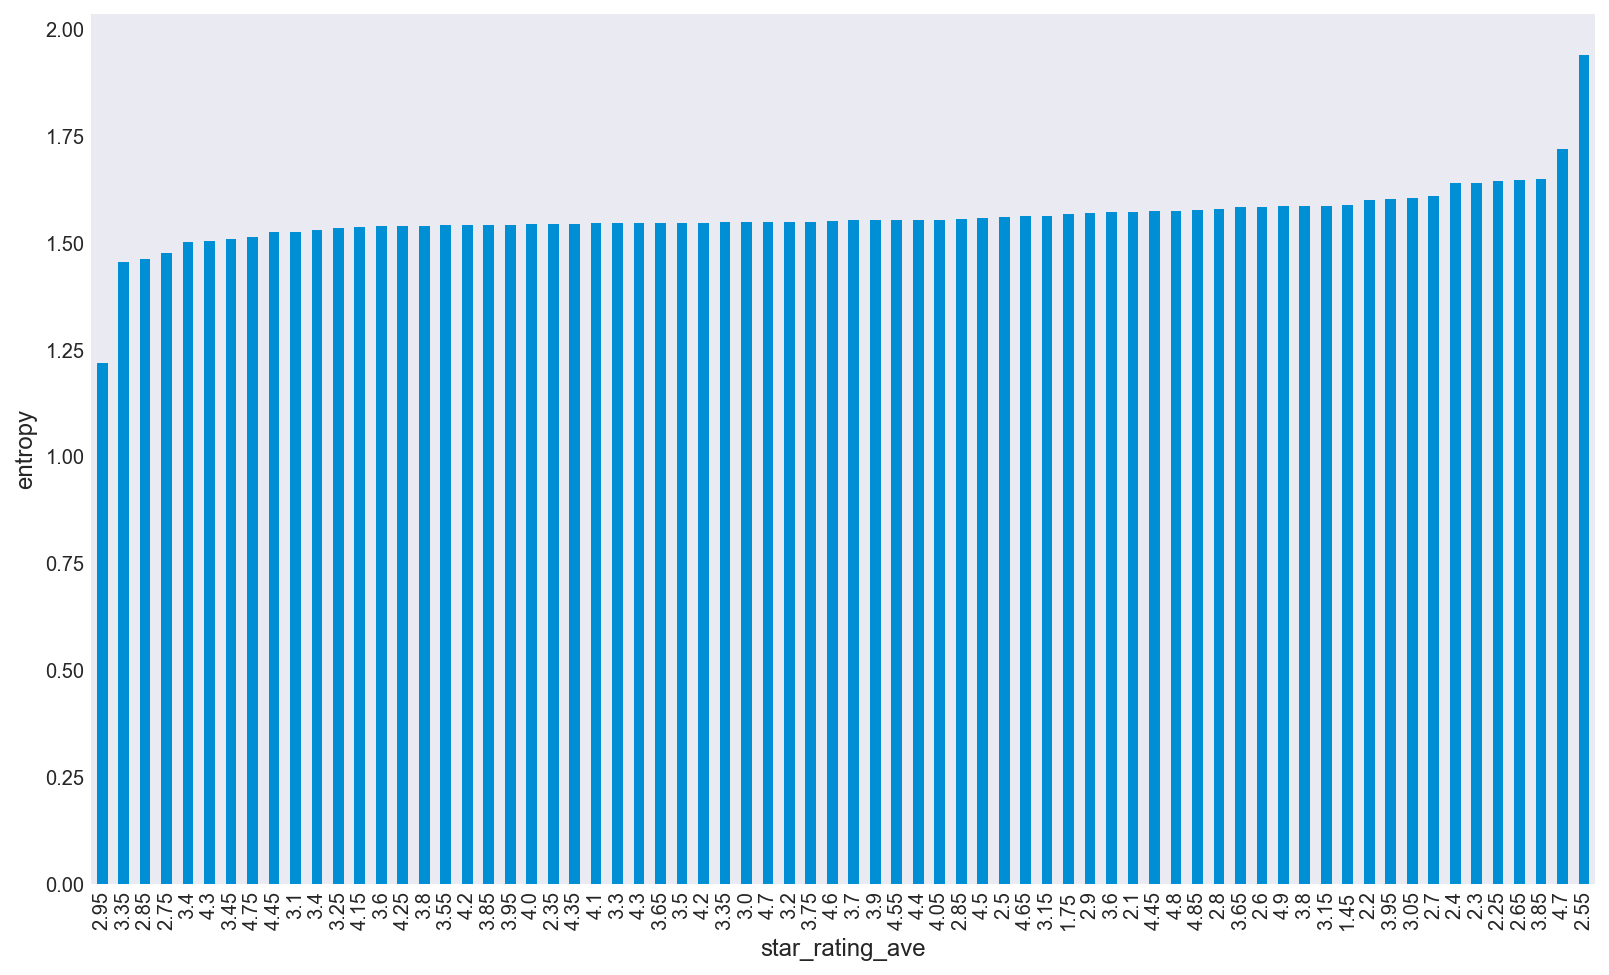

In [136]:
app_ui_exp.groupby('star_rating_ave')['info_gain'].mean().sort_values().plot.bar(figsize=(12,8)).set_ylabel('entropy');